In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
df = pd.read_excel("/kaggle/input/odir-5k-37-clases/odir-5k-37-clases.xlsx",engine="openpyxl")

df.head()



,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,branch retinal vein occlusion,cataract,central retinal vein occlusion,chorioretinal atrophy,diabetic retinopathy,...,retinal pigmentation,retinitis pigmentosa,severe nonproliferative retinopathy,severe proliferative diabetic retinopathy,spotted membranous change,suspected glaucoma,tessellated fundus,vitreous degeneration,wet age-related macular degeneration,white vessel
0,1,69,Female,0_right.jpg,normal fundus,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,57,Male,1_right.jpg,normal fundus,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,42,Male,2_right.jpg,moderate non proliferative retinopathy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,53,Male,4_right.jpg,mild nonproliferative retinopathy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,50,Female,5_right.jpg,moderate non proliferative retinopathy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print( df.columns[5:])
abreviaturas = [
    "BRARETVEIOCC",         # branch retinal vein occlusion
    "CATAR",    # Cataract
    "CENRETVEIOCC",    # central retinal vein occlusion
    "CARAT",    # Chorioretinal Atrophy
    "DIARET",       # Diabetic Retinopathy
    "DRUS",     # Drusen
    "DRAGMADE",   # Dry Age-Related Macular Degeneration
    "EPME",     # Epiretinal Membrane
    "EPMOM",    # Epiretinal Membrane over the Macula
    "GLAU",     # Glaucoma
    "HYPRE",    # Hypertensive Retinopathy
    "LASER",       # Laser Spot
    "LEDU",       # Lens Dust
    "MAEPME",      # Macular Epiretinal Membrane
    "MACULO",   # Maculopathy
    "MINORE",     # Mild Nonproliferative Retinopathy
    "MONOPRRE",   # Moderate Non Proliferative Retinopathy
    "MYEL",      # Myelinated Nerve Fibers
    "MYOP",     # Myopia Retinopathy
    "NORMFUND", # normal fundus
    "OPTDISEDE",      # Optic Disc Edema
    "PAMY",       # Pathological Myopia
    "PERIATRO",       # Peripapillary Atrophy
    "POSLASPHO",      # Post Laser Photocoagulation
    "PORELASU",     # Post Retinal Laser Surgery
    "PRODIRE",      # Proliferative Diabetic Retinopathy
    "REFMEOP",      # Refractive Media Opacity
    "RETINALPIG",       # Retinal Pigmentation
    "RETINIPIG",       # Retinitis Pigmentosa
    "SENORE",     # Severe Nonproliferative Retinopathy
    "SEPRODIRE",    # Severe Proliferative Diabetic Retinopathy
    "SPOMEMCHA",      # Spotted Membranous Change
    "SUSPGLAU",       # Suspected Glaucoma
    "TESSEFUN",       # Tessellated Fundus
    "VITDE",       # Vitreous Degeneration
    "WETAMD",   # Wet Age-Related Macular Degeneration
    "WHVES"        # White Vessel
]

print(len(abreviaturas))
print(len(df.columns[5:]))


Index(['branch retinal vein occlusion', 'cataract',
       'central retinal vein occlusion', 'chorioretinal atrophy',
       'diabetic retinopathy', 'drusen',
       'dry age-related macular degeneration', 'epiretinal membrane',
       'epiretinal membrane over the macula', 'glaucoma',
       'hypertensive retinopathy', 'laser spot', 'lens dust',
       'macular epiretinal membrane', 'maculopathy',
       'mild nonproliferative retinopathy',
       'moderate non proliferative retinopathy', 'myelinated nerve fibers',
       'myopia retinopathy', 'normal fundus', 'optic disc edema',
       'pathological myopia', 'peripapillary atrophy',
       'post laser photocoagulation', 'post retinal laser surgery',
       'proliferative diabetic retinopathy', 'refractive media opacity',
       'retinal pigmentation', 'retinitis pigmentosa',
       'severe nonproliferative retinopathy',
       'severe proliferative diabetic retinopathy',
       'spotted membranous change', 'suspected glaucoma', 'tess

# Creating Dataset from images

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import random
from tqdm import tqdm

dataset_dir = "/kaggle/input/myodir-5k-crop/myodir-crop"
image_size = 224
label_columns = df.columns[5:]

def create_dataset(df, image_column, label_columns, image_size, remove_class_15_count=200, remove_class_16_count=650, remove_class_19_count=2720):
    dataset = []
    class_16_removed = 0
    class_15_removed = 0
    class_19_removed = 0
    datagen = ImageDataGenerator(horizontal_flip=True,
                                 rotation_range=20, 
                                 fill_mode='constant',
                                 cval=0.
                                 )

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing images'):
        image_path = os.path.join(dataset_dir, row[image_column])
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0  

            label_edema = row[label_columns].values

            if label_edema[15] == 1 and class_15_removed < remove_class_15_count:
                class_15_removed += 1
                continue
            if label_edema[16] == 1 and class_16_removed < remove_class_16_count:
                class_16_removed += 1
                continue
            if label_edema[19] == 1 and class_19_removed < remove_class_19_count:
                class_19_removed += 1
                continue

            augmented_image = datagen.random_transform(image)
            dataset.append([np.array(augmented_image), label_edema])
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue

    random.shuffle(dataset)
    return dataset

dataset = create_dataset(df, "Fundus", label_columns, 224)


Processing images: 100%|██████████| 6799/6799 [05:22<00:00, 21.05it/s]


In [6]:
print(abreviaturas)

['BRARETVEIOCC', 'CATAR', 'CENRETVEIOCC', 'CARAT', 'DIARET', 'DRUS', 'DRAGMADE', 'EPME', 'EPMOM', 'GLAU', 'HYPRE', 'LASER', 'LEDU', 'MAEPME', 'MACULO', 'MINORE', 'MONOPRRE', 'MYEL', 'MYOP', 'NORMFUND', 'OPTDISEDE', 'PAMY', 'PERIATRO', 'POSLASPHO', 'PORELASU', 'PRODIRE', 'REFMEOP', 'RETINALPIG', 'RETINIPIG', 'SENORE', 'SEPRODIRE', 'SPOMEMCHA', 'SUSPGLAU', 'TESSEFUN', 'VITDE', 'WETAMD', 'WHVES']


LASER


<Figure size 2000x1000 with 0 Axes>

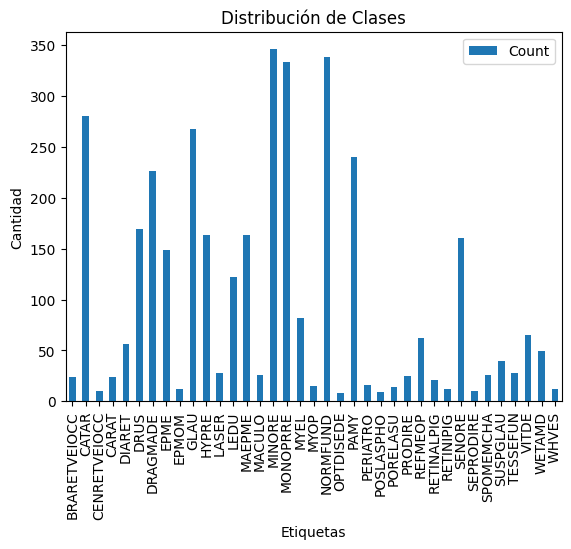

In [7]:
import matplotlib.pyplot as plt
import numpy as np

labels_from_dataset = np.array([item[1] for item in dataset])

class_counts = {label: 0 for label in abreviaturas}
print(abreviaturas[11])
for labels in labels_from_dataset:
    for i, label in enumerate(abreviaturas):
        class_counts[label] += labels[i]


counts_df = pd.DataFrame(list(class_counts.items()), columns=['Label', 'Count']).set_index('Label')


plt.figure(figsize=(20, 10))
counts_df.plot(kind='bar')
plt.title('Distribución de Clases')
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad')
plt.show()



# Dividing dataset into x(features) & y(target)

In [8]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

Train Test Split (80/20)

In [9]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [10]:
print(len(y_train_val))
print(len(y_test))

2583
646


# Creating Model

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet  import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.densenet  import DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

inception = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

def model_build():
    model = tf.keras.Sequential()
    model.add(inception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='sigmoid'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(37, activation='sigmoid'))

    return model


for layer in inception.layers:
    layer.trainable = False

for layer in inception.layers[-32:]:
    layer.trainable = True


model = model_build()



"import tensorflow as tf\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.applications.resnet50 import ResNet50\nfrom tensorflow.keras.applications import DenseNet121\nfrom tensorflow.keras.applications.vgg16 import VGG16\nfrom tensorflow.keras.applications.vgg19 import VGG19\nfrom tensorflow.keras.applications.inception_v3 import InceptionV3\nfrom tensorflow.keras.applications.xception import Xception\nfrom tensorflow.keras.applications.efficientnet  import EfficientNetB0\nfrom tensorflow.keras.applications.resnet import ResNet152\nfrom tensorflow.keras.applications.nasnet import NASNetLarge\nfrom tensorflow.keras.applications.densenet  import DenseNet201\nfrom tensorflow.keras.regularizers import l2\nfrom tensorflow.keras.optimizers import Adam\n\ndensenet = InceptionV3(\n    weights='imagenet',\n    include_top=False,\n    input_shape=(224,224,3)\n)\n#build a model with a densenet layers\ndef model_build():\n    model = tf.keras.Sequential()\n    model.add(densene

In [12]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)


In [14]:
for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_val, y_train_val)):
    print(f"Training on fold {fold+1}/{n_splits}")

   
    x_train_fold, y_train_fold = x[train_idx], y[train_idx]
    x_val_fold, y_val_fold = x[val_idx], y[val_idx]
    x_train_fold, y_train_fold = x[train_idx], y[train_idx]
    x_val_fold, y_val_fold = x[val_idx], y[val_idx]
    x_train_fold = x_train_fold.astype('float32')
    y_train_fold = y_train_fold.astype('float32')
    x_val_fold = x_val_fold.astype('float32')
    y_val_fold = y_val_fold.astype('float32')
 
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

    history = model.fit(
        x_train_fold, y_train_fold, 
        batch_size=16, 
        epochs=20, 
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
     
    )




Training on fold 1/5


Epoch 1/20
130/130 [==============================] - 100s 747ms/step - loss: 0.5894 - binary_accuracy: 0.7760 - val_loss: 0.3814 - val_binary_accuracy: 0.9692 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 95s 727ms/step - loss: 0.2133 - binary_accuracy: 0.9696 - val_loss: 0.1796 - val_binary_accuracy: 0.9692 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 93s 717ms/step - loss: 0.1260 - binary_accuracy: 0.9697 - val_loss: 0.1333 - val_binary_accuracy: 0.9671 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 91s 702ms/step - loss: 0.1189 - binary_accuracy: 0.9698 - val_loss: 0.1776 - val_binary_accuracy: 0.9556 - lr: 0.0010
Epoch 5/20
130/130 [==============================] - 91s 697ms/step - loss: 0.1153 - binary_accuracy: 0.9697 - val_loss: 0.1282 - val_binary_accuracy: 0.9676 - lr: 0.0010
Epoch 6/20
130/130 [==============================] - 92s 705ms/step - loss: 0.1128 - binary_accuracy: 0.9699 - val_loss: 0.1162 - val_bina

Epoch 1/20
130/130 [==============================] - 96s 719ms/step - loss: 0.0651 - binary_accuracy: 0.9807 - val_loss: 0.0489 - val_binary_accuracy: 0.9843 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 91s 698ms/step - loss: 0.0460 - binary_accuracy: 0.9854 - val_loss: 0.0461 - val_binary_accuracy: 0.9850 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 90s 691ms/step - loss: 0.0342 - binary_accuracy: 0.9894 - val_loss: 0.0493 - val_binary_accuracy: 0.9823 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 91s 704ms/step - loss: 0.0241 - binary_accuracy: 0.9929 - val_loss: 0.0489 - val_binary_accuracy: 0.9827 - lr: 0.0010
Epoch 5/20
130/130 [==============================] - 91s 698ms/step - loss: 0.0394 - binary_accuracy: 0.9864 - val_loss: 0.0644 - val_binary_accuracy: 0.9784 - lr: 0.0010
Epoch 6/20
130/130 [==============================] - 91s 700ms/step - loss: 0.0201 - binary_accuracy: 0.9943 - val_loss: 0.0519 - val_binar

Epoch 1/20
130/130 [==============================] - 96s 721ms/step - loss: 0.0289 - binary_accuracy: 0.9915 - val_loss: 0.0120 - val_binary_accuracy: 0.9964 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 91s 698ms/step - loss: 0.0211 - binary_accuracy: 0.9929 - val_loss: 0.0146 - val_binary_accuracy: 0.9958 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 91s 704ms/step - loss: 0.0095 - binary_accuracy: 0.9975 - val_loss: 0.0071 - val_binary_accuracy: 0.9986 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 92s 709ms/step - loss: 0.0065 - binary_accuracy: 0.9984 - val_loss: 0.0075 - val_binary_accuracy: 0.9980 - lr: 0.0010
Epoch 5/20
130/130 [==============================] - 92s 706ms/step - loss: 0.0050 - binary_accuracy: 0.9989 - val_loss: 0.0091 - val_binary_accuracy: 0.9975 - lr: 0.0010
Epoch 6/20
130/130 [==============================] - 92s 710ms/step - loss: 0.0047 - binary_accuracy: 0.9990 - val_loss: 0.0141 - val_binar

Epoch 1/20
130/130 [==============================] - 95s 708ms/step - loss: 0.0082 - binary_accuracy: 0.9973 - val_loss: 0.0048 - val_binary_accuracy: 0.9985 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 90s 689ms/step - loss: 0.0052 - binary_accuracy: 0.9985 - val_loss: 0.0039 - val_binary_accuracy: 0.9991 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 91s 697ms/step - loss: 0.0043 - binary_accuracy: 0.9987 - val_loss: 0.0029 - val_binary_accuracy: 0.9993 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 88s 677ms/step - loss: 0.0045 - binary_accuracy: 0.9987 - val_loss: 0.0029 - val_binary_accuracy: 0.9992 - lr: 0.0010
Epoch 5/20
130/130 [==============================] - 89s 689ms/step - loss: 0.0039 - binary_accuracy: 0.9989 - val_loss: 0.0038 - val_binary_accuracy: 0.9989 - lr: 0.0010
Epoch 6/20
130/130 [==============================] - 90s 688ms/step - loss: 0.0034 - binary_accuracy: 0.9992 - val_loss: 0.0061 - val_binar

Epoch 1/20
130/130 [==============================] - 96s 713ms/step - loss: 0.0059 - binary_accuracy: 0.9981 - val_loss: 0.0057 - val_binary_accuracy: 0.9978 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 94s 725ms/step - loss: 0.0038 - binary_accuracy: 0.9989 - val_loss: 0.0021 - val_binary_accuracy: 0.9994 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 93s 713ms/step - loss: 0.0026 - binary_accuracy: 0.9993 - val_loss: 0.0012 - val_binary_accuracy: 0.9999 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 92s 710ms/step - loss: 0.0024 - binary_accuracy: 0.9993 - val_loss: 0.0023 - val_binary_accuracy: 0.9996 - lr: 0.0010
Epoch 5/20
130/130 [==============================] - 93s 715ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - lr: 0.0010
Epoch 6/20
130/130 [==============================] - 92s 711ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - val_loss: 0.0014 - val_binar

In [15]:
print(history.history)

{'loss': [0.005863636266440153, 0.0037562858778983355, 0.0026257415302097797, 0.0023611695505678654, 0.002190436003729701, 0.001932912622578442, 0.002225644886493683, 0.0024385428987443447, 0.0041203792206943035, 0.0019371247617527843, 0.0015425484161823988, 0.0017626178450882435, 0.002396173309534788], 'binary_accuracy': [0.9981308579444885, 0.998914897441864, 0.9992810487747192, 0.9992680549621582, 0.9993988275527954, 0.999477207660675, 0.9993987083435059, 0.9992810487747192, 0.9986796975135803, 0.9995555281639099, 0.9996992945671082, 0.9995033144950867, 0.9993464946746826], 'val_loss': [0.005669869016855955, 0.0021485798060894012, 0.0012237414484843612, 0.0023278407752513885, 0.0014744068030267954, 0.001410550787113607, 0.004384079948067665, 0.0019221437396481633, 0.004611959680914879, 0.01342918910086155, 0.0024370402097702026, 0.004875203128904104, 0.004353970289230347], 'val_binary_accuracy': [0.9977999925613403, 0.9994238615036011, 0.9999476075172424, 0.9995810389518738, 0.99958

In [16]:
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
loss, accuracy = model.evaluate(x_test, y_test)
print("loss:", loss)
print("Accuracy:", accuracy)


21/21 [==============================] - 4s 193ms/step - loss: 0.0447 - binary_accuracy: 0.9933
loss: 0.044666457921266556
Accuracy: 0.9933478236198425


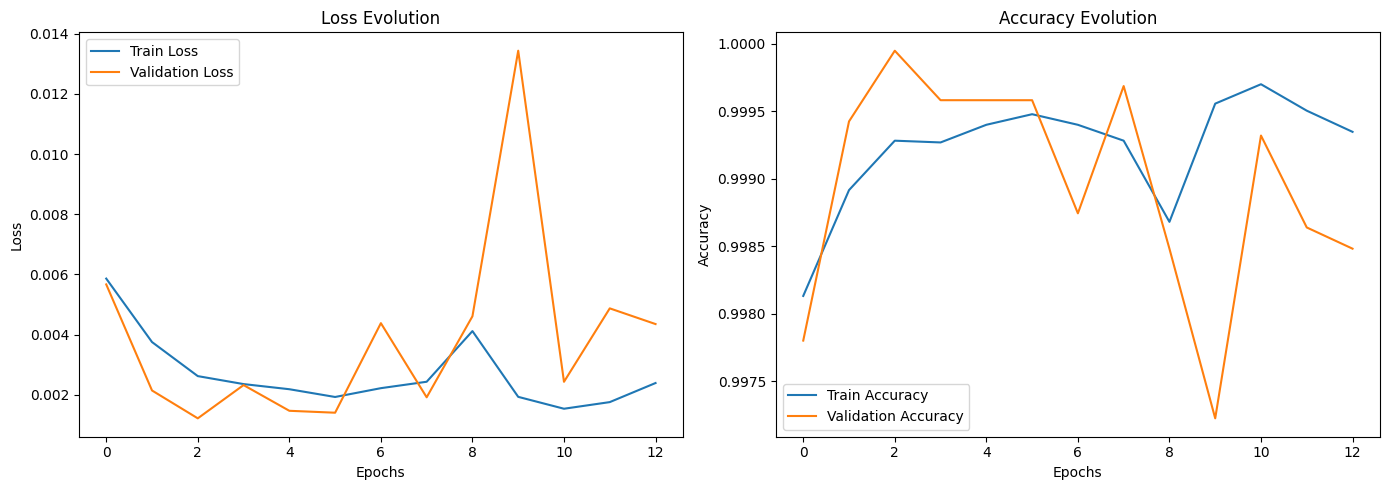

In [17]:

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)

plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()




21/21 [==============================] - 4s 191ms/step


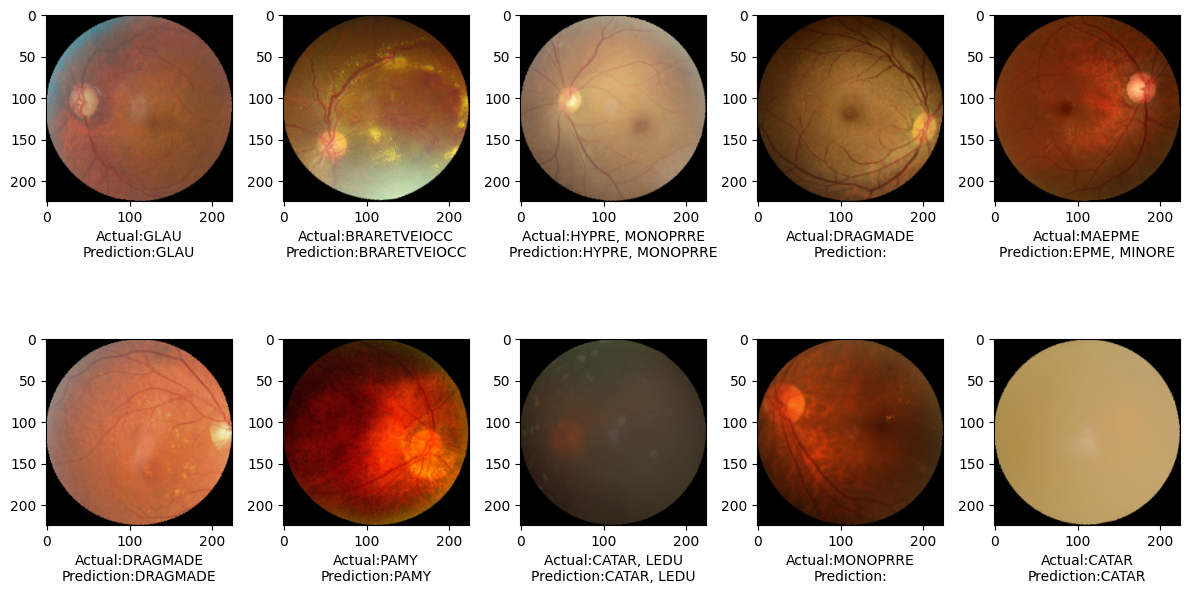

In [18]:
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

y_pred_probs = model.predict(x_test)

threshold = 0.5
y_pred_classes = (y_pred_probs > threshold).astype(int)

y_true_classes = y_test
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    categories = y_true_classes[sample]
    pred_categories = y_pred_classes[sample]
    

    labels = [abreviaturas[j] for j in range(len(categories)) if categories[j] == 1]
    pred_labels = [abreviaturas[j] for j in range(len(pred_categories)) if pred_categories[j] == 1]
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(', '.join(labels), ', '.join(pred_labels)))
plt.tight_layout()


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd


prediction_test = model.predict(x_test)



prediction_test_rounded = (prediction_test > 0.5).astype(int)



zero_division = 1



precision_test = precision_score(y_test, prediction_test_rounded, average='samples', zero_division=zero_division)
recall_test = recall_score(y_test, prediction_test_rounded, average='samples')
f1_test = f1_score(y_test, prediction_test_rounded, average='samples', zero_division=zero_division)



evaluation = pd.DataFrame({
    'Model': ['Neural Network'],
   
    'Precision(test)': [precision_test],
    'Recall(test)': [recall_test],
    'F1_score(test)': [f1_test],
   
})

print(evaluation)

21/21 [==============================] - 4s 180ms/step
            Model  Precision(test)  Recall(test)  F1_score(test)
0  Neural Network         0.930083      0.851393        0.916151


In [20]:
model.save("model_37_clases_best.h5")

/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
y_pred_classes

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



for i, label in enumerate(label_columns):

    cm = confusion_matrix(y_true_classes[:, i], y_pred_classes[:, i])
    plt.figure(figsize=(10,7))
    sns.set(style="white")
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Matriz de Confusión para la etiqueta: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.savefig(f"confusion_matrix_{label}.png", bbox_inches='tight', transparent=False)
    plt.close()


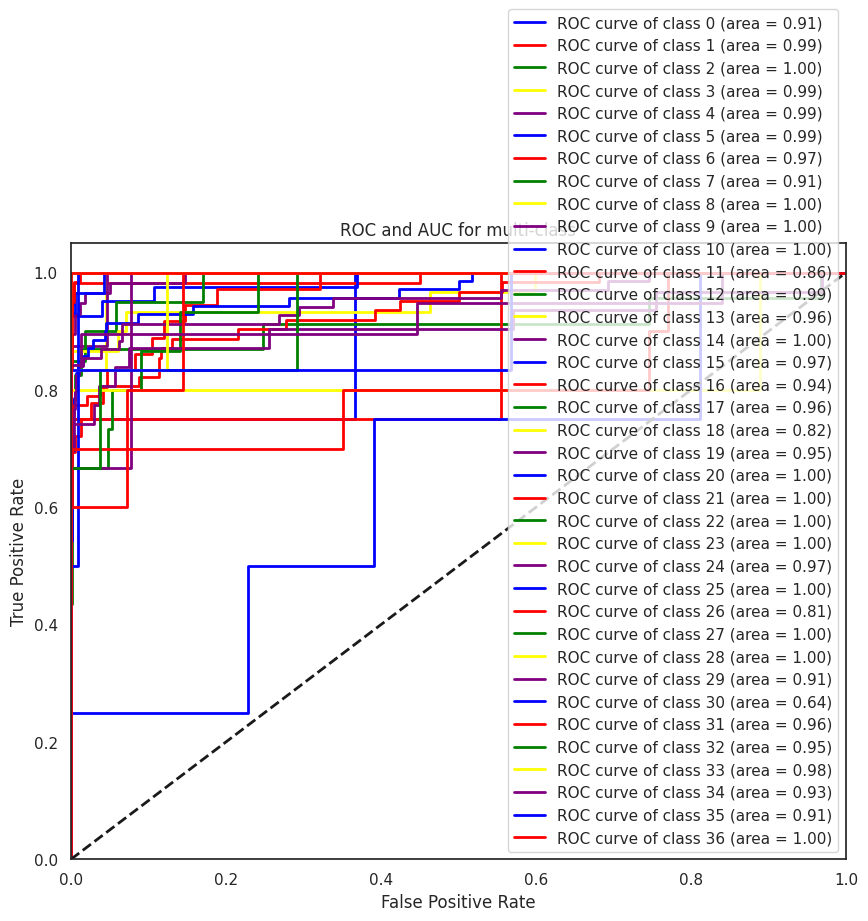

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 37

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC for multi-class')
plt.legend(loc="lower right")
plt.show()
